In [73]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import time
import pickle

import plotly
import plotly.graph_objs as go
import chart_studio.plotly as py
from chart_studio.plotly import plot, iplot
import plotly.express as px

# Setting pandas to display columns
pd.set_option('display.max_columns', None)

In [74]:
nfl_small2_end_of_drive = pd.read_csv('nfl_small_end_of_drive.csv',index_col=1)
nfl_small2_end_of_drive['KC'] = nfl_small2_end_of_drive['KC'].astype('str')
nfl_small2_end_of_drive['LAC'] = nfl_small2_end_of_drive['LAC'].astype('str')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (75,76,77,78,80,81,82,84,85,86,87,90,92,97,98,99,104,105) have mixed types. Specify dtype option on import or set low_memory=False.



In [75]:
nfl_small2_end_of_drive.head()

index     game_id            game_date   time  \
play_id                                                   
36       270409  2015091000  2015-09-10 00:00:00  15:00   
51       270410  2015091000  2015-09-10 00:00:00  15:00   
72       270411  2015091000  2015-09-10 00:00:00  14:21   
101      270412  2015091000  2015-09-10 00:00:00  14:04   
122      270413  2015091000  2015-09-10 00:00:00  13:26   

         quarter_seconds_remaining  half_seconds_remaining  \
play_id                                                      
36                           900.0                  1800.0   
51                           900.0                  1800.0   
72                           861.0                  1761.0   
101                          844.0                  1744.0   
122                          806.0                  1706.0   

         game_seconds_remaining game_half  quarter_end  qtr home_team  \
play_id                                                                 
36                       3600.0     Half1            0    1        NE   
51                       3600.0     Half1            0    1        NE   
72                       3561.0     Half1            0    1        NE   
101                      3544.0     Half1            0    1        NE   
122                      3506.0     Half1            0    1        NE   

        away_team posteam posteam_type defteam side_of_field  yardline_100  \
play_id                                                                      
36            PIT     PIT         away      NE            NE          35.0   
51            PIT     PIT         away      NE           PIT          80.0   
72            PIT     PIT         away      NE           PIT          62.0   
101           PIT     PIT         away      NE           PIT          53.0   
122           PIT     PIT         away      NE            NE          49.0   

         drive  sp  down  goal_to_go   yrdln  ydstogo  ydsnet  \
play_id                                                         
36           1   0   NaN         0.0   NE 35        0       0   
51           1   0   1.0         0.0  PIT 20       10      18   
72           1   0   1.0         0.0  PIT 38       10      31   
101          1   0   2.0         0.0  PIT 47        1      31   
122          1   0   1.0         0.0   NE 49       10      45   

                                                      desc play_type  \
play_id                                                                
36       S.Gostkowski kicks 65 yards from NE 35 to end ...   kickoff   
51       (15:00) De.Williams right tackle to PIT 38 for...       run   
72       (14:21) B.Roethlisberger pass short right to A...      pass   
101      (14:04) De.Williams right guard to NE 49 for 4...       run   
122      (13:26) B.Roethlisberger pass short right to H...      pass   

         yards_gained pass_length  air_yards  yards_after_catch  \
play_id                                                           
36                0.0           0        0.0                0.0   
51               18.0           0        0.0                0.0   
72                9.0       short       -4.0               13.0   
101               4.0           0        0.0                0.0   
122              14.0       short        9.0                5.0   

        field_goal_result  kick_distance extra_point_result  \
play_id                                                       
36                    NaN            NaN                NaN   
51                    NaN            NaN                NaN   
72                    NaN            NaN                NaN   
101                   NaN            NaN                NaN   
122                   NaN            NaN                NaN   

        two_point_conv_result td_team  total_home_score  total_away_score  \
play_id                                                                     
36                        NaN     NaN                 0                 0  

In [76]:
# Using a form of Joey's agg function
def my_aggfunc(x):
    values = {
        'pass_home':x[x['posteam_type']=='home']['play_type'].eq('pass').sum(),
        'pass_away':x[x['posteam_type']=='away']['play_type'].eq('pass').sum(),
        
        'run_home':x[x['posteam_type']=='home']['play_type'].eq('run').sum(),
        'run_away':x[x['posteam_type']=='away']['play_type'].eq('run').sum(),
        
        'TO_home':x[x['posteam_type']=='home']['INT'].sum() +\
        x[x['posteam_type']=='home']['fumble'].sum(),
        'TO_away':x[x['posteam_type']=='away']['INT'].sum() +\
        x[x['posteam_type']=='away']['fumble'].sum(),
        
        'yards_home':x[(x['posteam_type']=='home') & (x['end_of_drive']==1)]['ydsnet'].sum(),
        'yards_away':x[(x['posteam_type']=='away') & (x['end_of_drive']==1)]['ydsnet'].sum(),
        
        'fg_at_home':x[(x['posteam_type']=='home')&(x['play_type']=='field_goal')]['play_type'].count(),
        'fg_at_away':x[(x['posteam_type']=='away')&(x['play_type']=='field_goal')]['play_type'].count(),
        
        'fg_md_home':x[(x['posteam_type']=='home')&(x['play_type']=='field_goal')]['play_type'].count(),
        'fg_md_away':x[(x['posteam_type']=='away')&(x['play_type']=='field_goal')]['play_type'].count(),
        
        'pass_yards_home':x[(x['posteam_type']=='home')&(x['play_type']=='pass')]['yards_gained'].sum(),
        'pass_yards_away':x[(x['posteam_type']=='away')&(x['play_type']=='pass')]['yards_gained'].sum(),
        
        'run_yards_home':x[(x['posteam_type']=='home')&(x['play_type']=='run')]['yards_gained'].sum(),
        'run_yards_away':x[(x['posteam_type']=='away')&(x['play_type']=='run')]['yards_gained'].sum(),
        
        'dew_point':np.average(x['Dewpoint (°C)']),
        'Humidity':np.average(x['Humidity (%)']),
        'precip':np.sum(x['Precipitation (mm)']),
        'temp':np.average(x['Temperature (°C)']),
        'wind_speed':np.average(x['Wind Speed (km/h)'])
        
    }
    return pd.Series(values)

In [77]:
new_df = pd.DataFrame()
new_df = nfl_small2_end_of_drive.groupby(['game_id']).apply(my_aggfunc)

In [78]:
new_df['home_team'] = nfl_small2_end_of_drive.groupby('game_id')['home_team'].first()
new_df['away_team'] = nfl_small2_end_of_drive.groupby('game_id')['away_team'].first()
new_df['home_score'] = nfl_small2_end_of_drive.groupby('game_id')['total_home_score'].last()
new_df['away_score'] = nfl_small2_end_of_drive.groupby('game_id')['total_away_score'].last()

In [79]:
new_df = new_df.merge(nfl_small2_end_of_drive[['game_id','Roof']].drop_duplicates(), how='left', on='game_id')

In [80]:
new_df.head()

game_id  pass_home  pass_away  run_home  run_away  TO_home  TO_away  \
0  2015091000       34.0       42.0      23.0      25.0      1.0      2.0   
1  2015091300       36.0       23.0      33.0      28.0      1.0      0.0   
2  2015091301       29.0       47.0      26.0      32.0      3.0      1.0   
3  2015091302       44.0       33.0      21.0      33.0      4.0      1.0   
4  2015091303       32.0       37.0      36.0      17.0      4.0      2.0   

   yards_home  yards_away  fg_at_home  fg_at_away  fg_md_home  fg_md_away  \
0       366.0       429.0         0.0         4.0         0.0         4.0   
1       416.0       336.0         3.0         1.0         3.0         1.0   
2       354.0       338.0         2.0         3.0         2.0         3.0   
3       255.0       253.0         2.0         4.0         2.0         4.0   
4       290.0       264.0         2.0         1.0         2.0         1.0   

   pass_yards_home  pass_yards_away  run_yards_home  run_yards_away  \
0            281.0            332.0            82.0           134.0   
1            213.0            189.0           189.0           134.0   
2            276.0            219.0            76.0           127.0   
3            169.0            158.0            96.0           107.0   
4            188.0            182.0           162.0            75.0   

   dew_point   Humidity  precip       temp  wind_speed home_team away_team  \
0  16.527976  88.303571   25.65  18.510714   25.032143        NE       PIT   
1   6.063905  40.639053    0.00  19.808284   14.991716       CHI        GB   
2   6.183799  34.815642    0.00  22.597207   10.918436        LA       SEA   
3  15.875723  52.312139    0.00  26.475723   11.907514       JAX       CAR   
4   9.253049  41.969512    0.00  22.891463   23.589634       WAS       MIA   

   home_score  away_score   Roof  
0          28          21   Open  
1          23          31   Open  
2          33          29  Fixed  
3           9          19   Open  
4          10          16   Open

In [81]:
test_df = new_df.reset_index()[['game_id','home_team','away_team']]\
                .melt(id_vars='game_id',var_name = 'home_away',value_name="Team")
test_df.head(2)

game_id  home_away Team
0  2015091000  home_team   NE
1  2015091300  home_team  CHI

In [82]:
test_df_home = test_df.merge(new_df.reset_index(),how='inner',left_on=['game_id','Team'],\
                             right_on=['game_id','home_team'])

In [83]:
# Setting variables for Home Team
test_df_home['team_against'] = test_df_home[test_df_home['home_away']=='home_team']['away_team']
test_df_home['score'] = test_df_home[test_df_home['home_away']=='home_team']['home_score']
test_df_home['score_against'] = test_df_home[test_df_home['home_away']=='home_team']['away_score']

test_df_home['yards'] = test_df_home[test_df_home['home_away']=='home_team']['yards_home']
test_df_home['yards_against'] = test_df_home[test_df_home['home_away']=='home_team']['yards_away']

test_df_home['run_plays'] = test_df_home[test_df_home['home_away']=='home_team']['run_home']
test_df_home['run_plays_against'] = test_df_home[test_df_home['home_away']=='home_team']['run_away']

test_df_home['pass_plays'] = test_df_home[test_df_home['home_away']=='home_team']['pass_home']
test_df_home['pass_plays_against'] = test_df_home[test_df_home['home_away']=='home_team']['pass_away']

test_df_home['to_for'] = test_df_home[test_df_home['home_away']=='home_team']['TO_home']
test_df_home['to_against'] = test_df_home[test_df_home['home_away']=='home_team']['TO_away']

test_df_home['fg_at'] = test_df_home[test_df_home['home_away']=='home_team']['fg_at_home']
test_df_home['fg_md'] = test_df_home[test_df_home['home_away']=='home_team']['fg_md_home']

test_df_home['fg_at_against'] = test_df_home[test_df_home['home_away']=='home_team']['fg_at_away']
test_df_home['fg_md_against'] = test_df_home[test_df_home['home_away']=='home_team']['fg_md_away']

test_df_home['pass_yards'] = test_df_home[test_df_home['home_away']=='home_team']['pass_yards_home']
test_df_home['pass_yards_against'] = test_df_home[test_df_home['home_away']=='home_team']['pass_yards_away']

test_df_home['run_yards'] = test_df_home[test_df_home['home_away']=='home_team']['run_yards_home']
test_df_home['run_yards_against'] = test_df_home[test_df_home['home_away']=='home_team']['run_yards_away']

In [84]:
# Creating away only df to merge records from home and away team stats
test_df_away = test_df.merge(new_df.reset_index(),how='inner',left_on=['game_id','Team'],right_on=['game_id','away_team'])

In [85]:
# Setting variables for Away Team
test_df_away['team_against'] = test_df_away[test_df_away['home_away']=='away_team']['home_team']
test_df_away['score'] = test_df_away[test_df_away['home_away']=='away_team']['away_score']
test_df_away['score_against'] = test_df_away[test_df_away['home_away']=='away_team']['home_score']

test_df_away['yards'] = test_df_away[test_df_away['home_away']=='away_team']['yards_away']
test_df_away['yards_against'] = test_df_away[test_df_away['home_away']=='away_team']['yards_home']

test_df_away['run_plays'] = test_df_away[test_df_away['home_away']=='away_team']['run_away']
test_df_away['run_plays_against'] = test_df_away[test_df_away['home_away']=='away_team']['run_home']

test_df_away['pass_plays'] = test_df_away[test_df_away['home_away']=='away_team']['pass_away']
test_df_away['pass_plays_against'] = test_df_away[test_df_away['home_away']=='away_team']['pass_home']

test_df_away['to_for'] = test_df_away[test_df_away['home_away']=='away_team']['TO_away']
test_df_away['to_against'] = test_df_away[test_df_away['home_away']=='away_team']['TO_home']

test_df_away['fg_at'] = test_df_away[test_df_away['home_away']=='away_team']['fg_at_away']
test_df_away['fg_md'] = test_df_away[test_df_away['home_away']=='away_team']['fg_md_away']

test_df_away['fg_at_against'] = test_df_away[test_df_away['home_away']=='away_team']['fg_at_home']
test_df_away['fg_md_against'] = test_df_away[test_df_away['home_away']=='away_team']['fg_md_home']

test_df_away['pass_yards'] = test_df_away[test_df_away['home_away']=='away_team']['pass_yards_away']
test_df_away['pass_yards_against'] = test_df_away[test_df_away['home_away']=='away_team']['pass_yards_home']

test_df_away['run_yards'] = test_df_away[test_df_away['home_away']=='away_team']['run_yards_away']
test_df_away['run_yards_against'] = test_df_away[test_df_away['home_away']=='away_team']['run_yards_home']

test_df_away[test_df_away['game_id']==2017090700]

game_id  home_away Team  index  pass_home  pass_away  run_home  \
511  2017090700  away_team   KC    511       39.0       38.0      34.0   

     run_away  TO_home  TO_away  yards_home  yards_away  fg_at_home  \
511      24.0      2.0      1.0       425.0       538.0         2.0   

     fg_at_away  fg_md_home  fg_md_away  pass_yards_home  pass_yards_away  \
511         0.0         2.0         0.0            247.0            352.0   

     run_yards_home  run_yards_away  dew_point   Humidity  precip       temp  \
511           125.0           191.0  11.439487  66.302564     0.0  17.814359   

     wind_speed home_team away_team  home_score  away_score  Roof  \
511   13.215385        NE        KC          27          42  Open   

    team_against  score  score_against  yards  yards_against  run_plays  \
511           NE     42             27  538.0          425.0       24.0   

     run_plays_against  pass_plays  pass_plays_against  to_for  to_against  \
511               34.0        38.0                39.0     1.0         2.0   

     fg_at  fg_md  fg_at_against  fg_md_against  pass_yards  \
511    0.0    0.0            2.0            2.0       352.0   

     pass_yards_against  run_yards  run_yards_against  
511               247.0      191.0              125.0

In [86]:
# Creating cols filter for new df
new_cols = ['game_id','Team','team_against','score','score_against','yards','yards_against','run_plays',\
            'run_plays_against','pass_plays','pass_plays_against','to_for','to_against','fg_at',\
           'fg_md','fg_at_against','fg_md_against','pass_yards','pass_yards_against','run_yards','run_yards_against',\
            'dew_point','Humidity','precip','temp','wind_speed','Roof']
            
            
            


In [87]:
# Combining home and away dfs
combined_df = test_df_home[new_cols].append(test_df_away[new_cols],ignore_index=True)
combined_df[combined_df['game_id']==2017090700]

game_id Team team_against  score  score_against  yards  \
511   2017090700   NE           KC     27             42  425.0   
1502  2017090700   KC           NE     42             27  538.0   

      yards_against  run_plays  run_plays_against  pass_plays  \
511           538.0       34.0               24.0        39.0   
1502          425.0       24.0               34.0        38.0   

      pass_plays_against  to_for  to_against  fg_at  fg_md  fg_at_against  \
511                 38.0     2.0         1.0    2.0    2.0            0.0   
1502                39.0     1.0         2.0    0.0    0.0            2.0   

      fg_md_against  pass_yards  pass_yards_against  run_yards  \
511             0.0       247.0               352.0      125.0   
1502            2.0       352.0               247.0      191.0   

      run_yards_against  dew_point   Humidity  precip       temp  wind_speed  \
511               191.0  11.439487  66.302564     0.0  17.814359   13.215385   
1502              125.0  11.439487  66.302564     0.0  17.814359   13.215385   

      Roof  
511   Open  
1502  Open

In [88]:
# Creating my target variable wins
combined_df.loc[combined_df['score'] > combined_df['score_against'],'win'] = 1

combined_df['win'].fillna(0,inplace=True)

In [89]:
# Creating additional variables
combined_df['pass_run_ratio'] = round(combined_df['pass_plays'] / combined_df['run_plays'],2)
combined_df['yard_diff'] = combined_df['yards'] - combined_df['yards_against']
combined_df['to_diff'] = combined_df['to_for'] - combined_df['to_against']

combined_df['fg_rate'] = round(combined_df['fg_md'] / combined_df['fg_at'],2)
combined_df['fg_rate_against'] = round(combined_df['fg_md_against'] / combined_df['fg_at_against'],2)

# Setting fg rates to 50% for teams not attempting field goals
combined_df['fg_rate'].fillna(0.5,inplace=True)
combined_df['fg_rate_against'].fillna(0.5,inplace=True)

combined_df['pass_yds_per_at'] = combined_df['pass_yards'] / combined_df['pass_plays']
combined_df['run_yds_per_at'] = combined_df['run_yards'] / combined_df['run_plays']

combined_df['pass_yds_per_at_against'] = combined_df['pass_yards_against'] / combined_df['pass_plays_against']
combined_df['run_yds_per_at_against'] = combined_df['run_yards_against'] / combined_df['run_plays_against']

In [90]:
import matplotlib as plt
%matplotlib inline

In [91]:
corr_data = combined_df[['Team','team_against','score','score_against','yards','yards_against','run_plays',\
            'run_plays_against','pass_plays','pass_plays_against','to_for','to_against','fg_at',\
           'fg_md','fg_at_against','fg_md_against','pass_yards','pass_yards_against','run_yards','run_yards_against',\
            'dew_point','Humidity','precip','temp','wind_speed','Roof']].corr()

corr_data

score  score_against     yards  yards_against  \
score               1.000000      -0.011774  0.657604       0.051191   
score_against      -0.011774       1.000000  0.051191       0.657604   
yards               0.657604       0.051191  1.000000       0.046549   
yards_against       0.051191       0.657604  0.046549       1.000000   
run_plays           0.373112      -0.347357  0.296027      -0.308231   
run_plays_against  -0.347357       0.373112 -0.308231       0.296027   
pass_plays         -0.117240       0.330410  0.236382       0.107839   
pass_plays_against  0.330410      -0.117240  0.107839       0.236382   
to_for             -0.345806       0.336779 -0.084739       0.017020   
to_against          0.336779      -0.345806  0.017020      -0.084739   
fg_at               0.146662      -0.185868  0.246801      -0.143859   
fg_md               0.146662      -0.185868  0.246801      -0.143859   
fg_at_against      -0.185868       0.146662 -0.143859       0.246801   
fg_md_against      -0.185868       0.146662 -0.143859       0.246801   
pass_yards          0.404912       0.183816  0.734671       0.139993   
pass_yards_against  0.183816       0.404912  0.139993       0.734671   
run_yards           0.390275      -0.207457  0.380082      -0.158624   
run_yards_against  -0.207457       0.390275 -0.158624       0.380082   
dew_point           0.049820       0.049820  0.064853       0.064853   
Humidity           -0.011631      -0.011631  0.016488       0.016488   
precip              0.042947       0.042947  0.045257       0.045257   
temp                0.050072       0.050072  0.045014       0.045014   
wind_speed         -0.068953      -0.068953 -0.057946      -0.057946   

                    run_plays  run_plays_against  pass_plays  \
score                0.373112          -0.347357   -0.117240   
score_against       -0.347357           0.373112    0.330410   
yards                0.296027          -0.308231    0.236382   
yards_against       -0.308231           0.296027    0.107839   
run_plays            1.000000          -0.304962   -0.208813   
run_plays_against   -0.304962           1.000000    0.276208   
pass_plays          -0.208813           0.276208    1.000000   
pass_plays_against   0.276208          -0.208813   -0.060920   
to_for              -0.210413           0.268598    0.390225   
to_against           0.268598          -0.210413   -0.212243   
fg_at                0.275877          -0.169253    0.134893   
fg_md                0.275877          -0.169253    0.134893   
fg_at_against       -0.169253           0.275877    0.079987   
fg_md_against       -0.169253           0.275877    0.079987   
pass_yards           0.012379           0.001323    0.597674   
pass_yards_against   0.001323           0.012379    0.164077   
run_yards            0.775768          -0.199008   -0.232852   
run_yards_against   -0.199008           0.775768    0.245161   
dew_point           -0.074891          -0.074891   -0.021350   
Humidity            -0.025186          -0.025186   -0.056906   
precip               0.004798           0.004798   -0.008694   
temp                -0.063552          -0.063552    0.009871   
wind_speed           0.003011           0.003011   -0.049605   

                    pass_plays_against    to_for  to_against     fg_at  \
score                         0.330410 -0.345806    0.336779  0.146662   
score_against                -0.117240  0.336779   -0.345806 -0.185868   
yards                         0.107839 -0.084739    0.017020  0.246801   
yards_against                 0.236382  0.017020   -0.084739 -0.143859   
run_plays                     0.276208 -0.210413    0.268598  0.275877   
run_plays_against            -0.208813  0.268598   -0.210413 -0.169253   
pass_plays                   -0.060920  0.390225   -0.212243  0.134893   
pass_plays_against            1.000000 -0.212243    0.390225  0.079987   
to_for                       -0.212243  1.000000   -0.205930 -0.187829   
to_against       

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

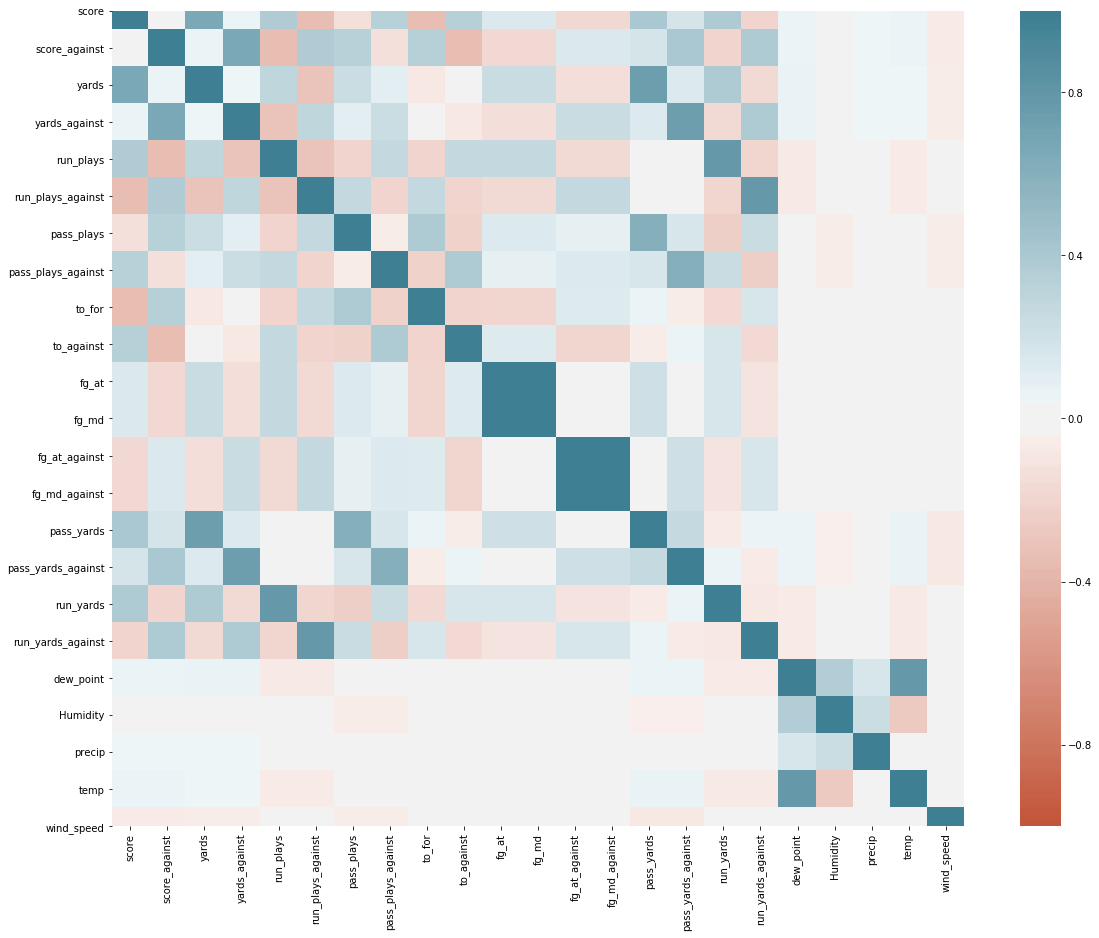

In [102]:
# Could filter to just rain games? or stadium type?
plt.subplots(figsize=(20,15))

sns.heatmap(corr_data,vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a714350>,
        ...,
        ...,
        ...,
       ...,
        ...,
        ...,
        ...,
      dtype=object)

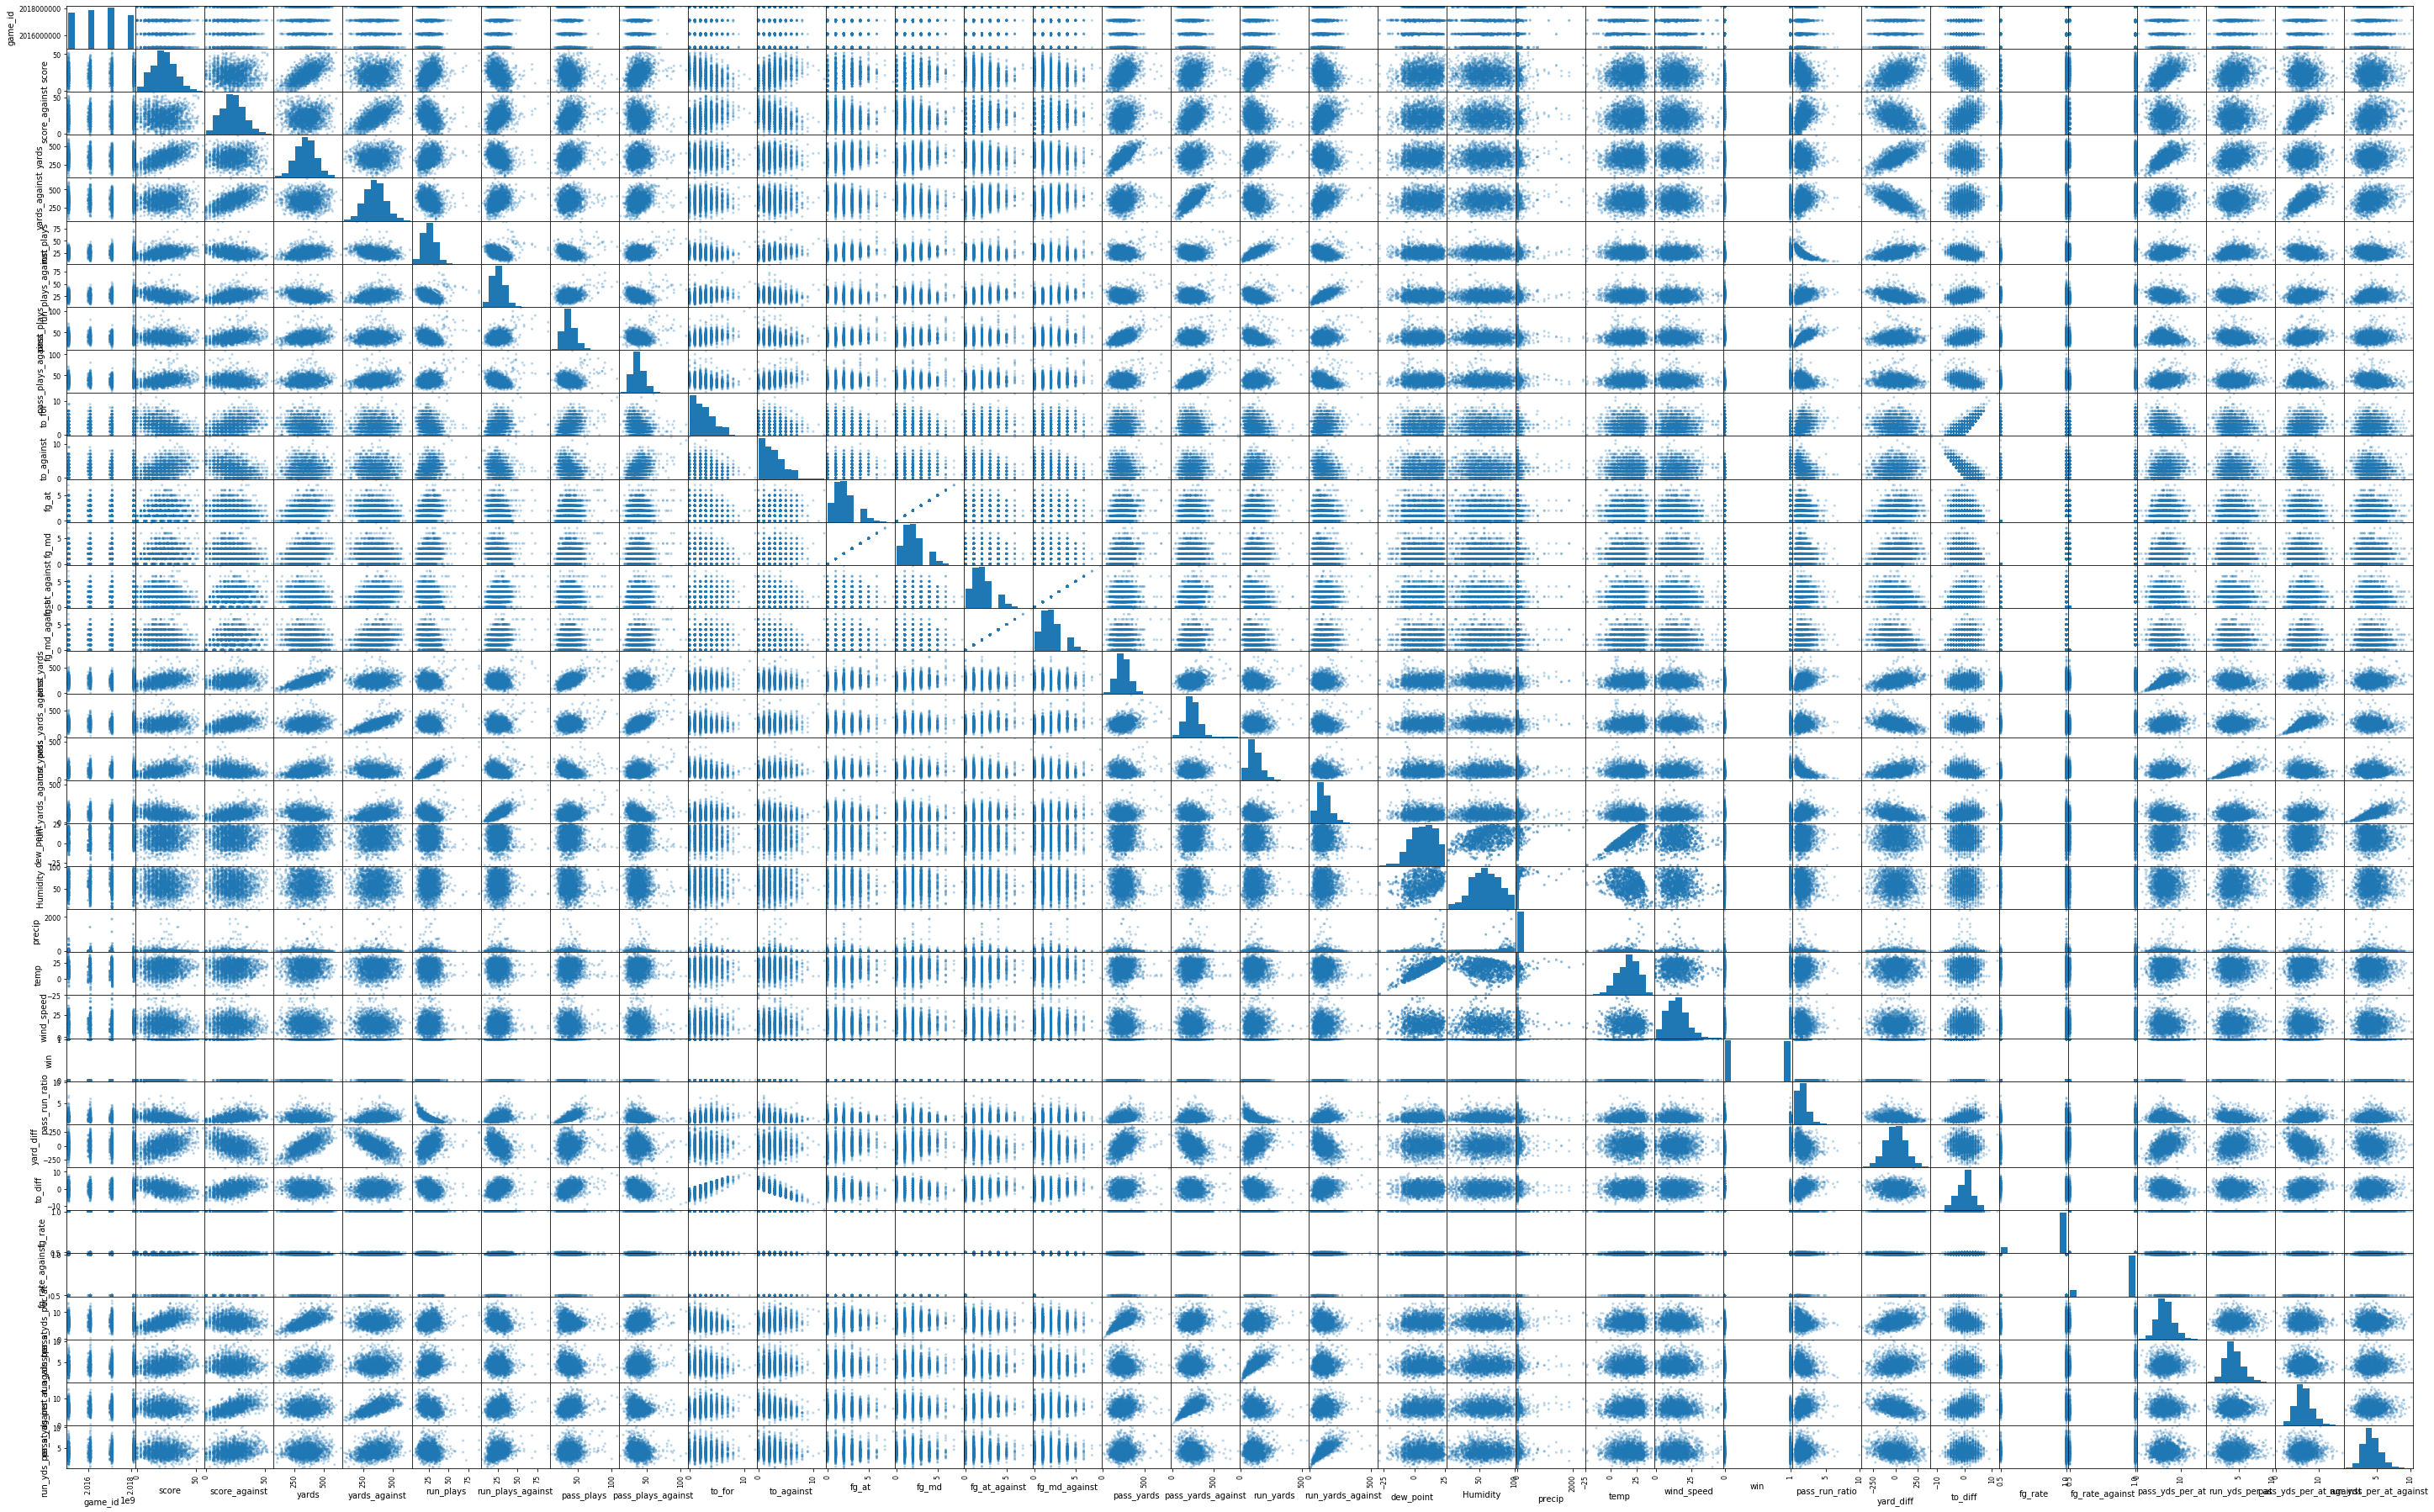

In [93]:
from pandas.plotting import scatter_matrix
scatter_matrix(combined_df,figsize=(50,32),alpha=0.3)